# LLM calls




In [15]:
import sys
from pathlib import Path
import re
from os import getenv
import pandas as pd
import numpy as np
from openai import OpenAI
import pickle

repo_root = Path(".").resolve().parents[1]
sys.path.append(str(repo_root / 'src'))

from llm_calling import extract_numeric_answer, create_probability_prompt, run_llm_call 
from yaml_utils import load_yaml

# Load all_bayesian_networks from disk
with open("bns.pkl", "rb") as f:
    all_bayesian_networks = pickle.load(f)

# Load df from CSV
df = pd.read_csv("bns_metadata.csv")

# Read the full_df DataFrame from a CSV file
full_df = pd.read_csv("queries.csv")
print("Loaded DataFrame from 'queries.csv'")
print(full_df.head())

Loaded DataFrame from 'queries.csv'
   achieved_tw     naming  alpha  seed  variant_index  num_edges  num_nodes  \
0            3  confusing    1.0    42              0          6          4   
1            3  confusing    1.0    42              0          6          4   
2            3  confusing    1.0    42              0          6          4   
3            3  confusing    1.0    42              0          6          4   
4            3  confusing    1.0    42              0          6          4   

   num_nodes/num_edges  avg_markov_blanket_size  bn_index  ...  \
0             0.666667                      3.0         0  ...   
1             0.666667                      3.0         0  ...   
2             0.666667                      3.0         0  ...   
3             0.666667                      3.0         0  ...   
4             0.666667                      3.0         0  ...   

   avg_markov_blanket_size_target min_distance_target_evidence  \
0                         

In [16]:
MODEL = "openai/gpt-5"
MODEL = "deepseek/deepseek-chat-v3.1:free"
MODEL = "openai/o3-mini-high"  

client = OpenAI(
    base_url="https://openrouter.ai/api/v1",
    api_key=getenv("OPENROUTER_API_KEY")
)

# Load prompts
prompt_path = repo_root / "notebooks" / "discrete" / "prompts.yaml"
prompts = load_yaml(prompt_path)

In [ ]:
# Optional: Call LLM on a subset AFTER query generation
# Provide indices of rows in full_df for which to call the LLM.
# Import _parse_field from bn_query_sweep instead of defining it locally
from experiments.bn_query_sweep import _parse_field, call_llm_for_query

# Ensure LLM columns exist
if 'llm_probability' not in full_df.columns:
    full_df['llm_probability'] = None
if 'llm_response' not in full_df.columns:
    full_df['llm_response'] = None

# Select which rows to send to LLM (example below commented out)
#selected_indices = list(full_df.sample(n=15, random_state=0).index)
selected_indices = list(full_df.index)

for ridx in selected_indices:
    row = full_df.iloc[ridx]
    bn = all_bayesian_networks[int(row['bn_index'])]['bn']
    query_vars = _parse_field(row['query_vars']) or []
    query_states = _parse_field(row['query_states']) or []
    evidence = _parse_field(row['evidence']) or None
    print(f"Processing BN {int(row['bn_index'])}/{len(all_bayesian_networks)}, Query {int(row['query_index'])}...")
    llm_prob, llm_response = call_llm_for_query(bn, query_vars, query_states, evidence)
    full_df.at[ridx, 'llm_probability'] = llm_prob
    full_df.at[ridx, 'llm_response'] = llm_response
    full_df.at[ridx, 'model'] = MODEL

Processing BN 19/34, Query 20...


INFO:httpx:HTTP Request: POST https://openrouter.ai/api/v1/chat/completions "HTTP/1.1 200 OK"


Processing BN 15/34, Query 15...


INFO:httpx:HTTP Request: POST https://openrouter.ai/api/v1/chat/completions "HTTP/1.1 200 OK"


Processing BN 8/34, Query 23...


INFO:httpx:HTTP Request: POST https://openrouter.ai/api/v1/chat/completions "HTTP/1.1 200 OK"


Processing BN 9/34, Query 4...


INFO:httpx:HTTP Request: POST https://openrouter.ai/api/v1/chat/completions "HTTP/1.1 200 OK"


Processing BN 10/34, Query 19...


INFO:httpx:HTTP Request: POST https://openrouter.ai/api/v1/chat/completions "HTTP/1.1 200 OK"


Processing BN 29/34, Query 5...


INFO:httpx:HTTP Request: POST https://openrouter.ai/api/v1/chat/completions "HTTP/1.1 200 OK"


Processing BN 10/34, Query 8...


INFO:httpx:HTTP Request: POST https://openrouter.ai/api/v1/chat/completions "HTTP/1.1 200 OK"


Processing BN 21/34, Query 8...


INFO:httpx:HTTP Request: POST https://openrouter.ai/api/v1/chat/completions "HTTP/1.1 200 OK"


Processing BN 2/34, Query 23...


INFO:httpx:HTTP Request: POST https://openrouter.ai/api/v1/chat/completions "HTTP/1.1 200 OK"


Processing BN 24/34, Query 25...


INFO:httpx:HTTP Request: POST https://openrouter.ai/api/v1/chat/completions "HTTP/1.1 200 OK"


Processing BN 9/34, Query 22...


INFO:httpx:HTTP Request: POST https://openrouter.ai/api/v1/chat/completions "HTTP/1.1 200 OK"


Processing BN 25/34, Query 0...


INFO:httpx:HTTP Request: POST https://openrouter.ai/api/v1/chat/completions "HTTP/1.1 200 OK"


Processing BN 25/34, Query 21...


INFO:httpx:HTTP Request: POST https://openrouter.ai/api/v1/chat/completions "HTTP/1.1 200 OK"


Processing BN 8/34, Query 17...


INFO:httpx:HTTP Request: POST https://openrouter.ai/api/v1/chat/completions "HTTP/1.1 200 OK"


Processing BN 33/34, Query 18...


INFO:httpx:HTTP Request: POST https://openrouter.ai/api/v1/chat/completions "HTTP/1.1 200 OK"


In [30]:
import datetime
import os
from pathlib import Path

date_now = datetime.datetime.now().strftime('%Y-%m-%d')
full_df['date'] = date_now

csv_path = Path("llm_responses.csv")
# If file does not exist, save with header; if exists, append without header.
if not csv_path.exists():
    full_df.to_csv(csv_path, index=False)
else:
    full_df.to_csv(csv_path, mode='a', header=False, index=False)
print("DataFrame with LLM responses appended to", csv_path)


DataFrame with LLM responses appended to llm_responses.csv


In [31]:
# Print rows with non-empty llm_probability
llm_rows = full_df[full_df['llm_probability'].notna()]
print(f"Found {len(llm_rows)} rows with LLM probability values:")
print("=" * 80)
display(llm_rows)

Found 15 rows with LLM probability values:


,achieved_tw,naming,alpha,seed,variant_index,num_edges,num_nodes,num_nodes/num_edges,avg_markov_blanket_size,bn_index,...,all_evidence_are_roots,all_evidence_are_leaves,all_target_are_roots,all_target_are_leaves,abs_diff,rel_diff,llm_probability,llm_response,model,date
45,3,confusing,1.0,44,0,10,6,0.600000,5.000000,2,...,False,False,False,False,0.110986,-0.554257,0.0903,"Final Answer: P(U_9d6udx=s0, M_clcji8=s0 | X_w...",openai/o3-mini-high,2025-11-02
101,4,confusing,1.0,50,0,19,8,0.421053,5.750000,8,...,False,False,False,False,0.123688,0.413057,0.3602,"Final Answer: P(A_dcka33=s1, A_l40h2y=s1 | O_n...",openai/o3-mini-high,2025-11-02
106,4,confusing,1.0,50,0,19,8,0.421053,5.750000,8,...,False,False,False,True,0.155729,0.234510,0.7541,"Final Answer: P(O_nhaatt=s1 | A_dcka33=s0, G_u...",openai/o3-mini-high,2025-11-02
111,4,confusing,0.5,51,0,19,8,0.421053,5.750000,9,...,False,False,False,False,0.556378,-0.845710,0.3661,"Final Answer: P(A_dcka33=s1 | G_u5vagt=s0, C_p...",openai/o3-mini-high,2025-11-02
118,4,confusing,0.5,51,0,19,8,0.421053,5.750000,9,...,False,False,False,False,0.117568,0.218479,0.3337,"Final Answer: P(C_p490cm=s1, G_u5vagt=s1 | O_n...",openai/o3-mini-high,2025-11-02
122,6,confusing,1.0,52,0,25,8,0.320000,6.750000,10,...,False,False,False,False,0.182190,0.398907,0.4593,"Final Answer: P(G_zwp5v0=s0 | W_zz5knb=s0, V_o...",openai/o3-mini-high,2025-11-02
125,6,confusing,1.0,52,0,25,8,0.320000,6.750000,10,...,False,False,False,False,0.180357,-0.295512,0.0812,"Final Answer: P(B_97fqlp=s1, V_2lnxw2=s0 | G_z...",openai/o3-mini-high,2025-11-02
152,4,confusing,0.5,57,0,21,10,0.476190,7.800000,15,...,True,False,False,False,0.114993,-0.240676,0.3627,"Final Answer: P(D_vyqi2q=s1, R_3o4z3k=s1 | E_0...",openai/o3-mini-high,2025-11-02
173,3,confusing,0.5,61,0,16,12,0.750000,4.166667,19,...,False,False,False,True,0.484484,-0.984579,0.0076,"Final Answer: P(L_u8nlyj=s1 | X_fb1gu5=s0, N_b...",openai/o3-mini-high,2025-11-02
179,4,confusing,0.5,63,0,19,12,0.631579,5.000000,21,...,False,True,True,False,0.121484,-0.132825,0.809,Final Answer: P(S_yrjlr4=s0 | T_bprvfu=s0) = 0...,openai/o3-mini-high,2025-11-02


In [34]:
# Display LLM performance statistics
print("LLM Performance Analysis:")
print("=" * 50)

# Count successful LLM responses
successful_llm = full_df['llm_probability'].notna().sum()
total_queries = len(full_df)
print(f"Successful LLM responses: {successful_llm}/{total_queries} ({successful_llm/total_queries*100:.1f}%)")

LLM Performance Analysis:
Successful LLM responses: 15/237 (6.3%)


In [35]:
# Calculate accuracy metrics for successful responses
if successful_llm > 0:
    # Filter to only successful LLM responses
    successful_df = full_df[full_df['llm_probability'].notna() & full_df['probability'].notna()]
    
    if len(successful_df) > 0:
        # Calculate absolute errors
        successful_df = successful_df.copy()
        successful_df['abs_error'] = abs(successful_df['llm_probability'] - successful_df['probability'])
        successful_df['rel_error'] = successful_df['abs_error'] / successful_df['probability']
        
        print(f"\nAccuracy Metrics (for {len(successful_df)} successful responses):")
        print(f"Mean Absolute Error: {successful_df['abs_error'].mean():.6f}")
        print(f"Mean Relative Error: {successful_df['rel_error'].mean():.6f}")
        print(f"Max Absolute Error: {successful_df['abs_error'].max():.6f}")
        print(f"Max Relative Error: {successful_df['rel_error'].max():.6f}")
        
        # Show some examples
        print(f"\nFirst 5 successful responses:")
        display(successful_df[['query_vars', 'query_states', 'evidence', 'probability', 'llm_probability', 'abs_error']].head())
    else:
        print("No successful LLM responses with exact inference results to compare.")
else:
    print("No successful LLM responses.")


Accuracy Metrics (for 15 successful responses):
Mean Absolute Error: 0.141246
Mean Relative Error: 0.473124
Max Absolute Error: 0.348764
Max Relative Error: 2.606727

First 5 successful responses:


,query_vars,query_states,evidence,probability,llm_probability,abs_error
45,"[np.str_('U_9d6udx'), np.str_('M_clcji8')]","['s0', 's0']","{np.str_('X_wzdhd9'): 's0', np.str_('K_5si3ik'...",0.089257,0.0903,0.001043
101,"[np.str_('A_dcka33'), np.str_('A_l40h2y')]","['s1', 's1']","{np.str_('O_nhaatt'): 's0', np.str_('G_u5vagt'...",0.423133,0.3602,0.062933
106,[np.str_('O_nhaatt')],['s1'],"{np.str_('A_dcka33'): 's0', np.str_('G_u5vagt'...",0.819791,0.7541,0.065691
111,[np.str_('A_dcka33')],['s1'],"{np.str_('G_u5vagt'): 's0', np.str_('C_p490cm'...",0.101505,0.3661,0.264595
118,"[np.str_('C_p490cm'), np.str_('G_u5vagt')]","['s1', 's1']","{np.str_('O_nhaatt'): 's1', np.str_('F_gwfc5h'...",0.655686,0.3337,0.321986


/tmp/ipykernel_58362/965101433.py:58: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(box_data, labels=labels)
/tmp/ipykernel_58362/965101433.py:58: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(box_data, labels=labels)
/tmp/ipykernel_58362/965101433.py:58: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(box_data, labels=labels)
/tmp/ipykernel_58362/965101433.py:58: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(box_data, labels=labels)
/tmp/ipykernel_58362

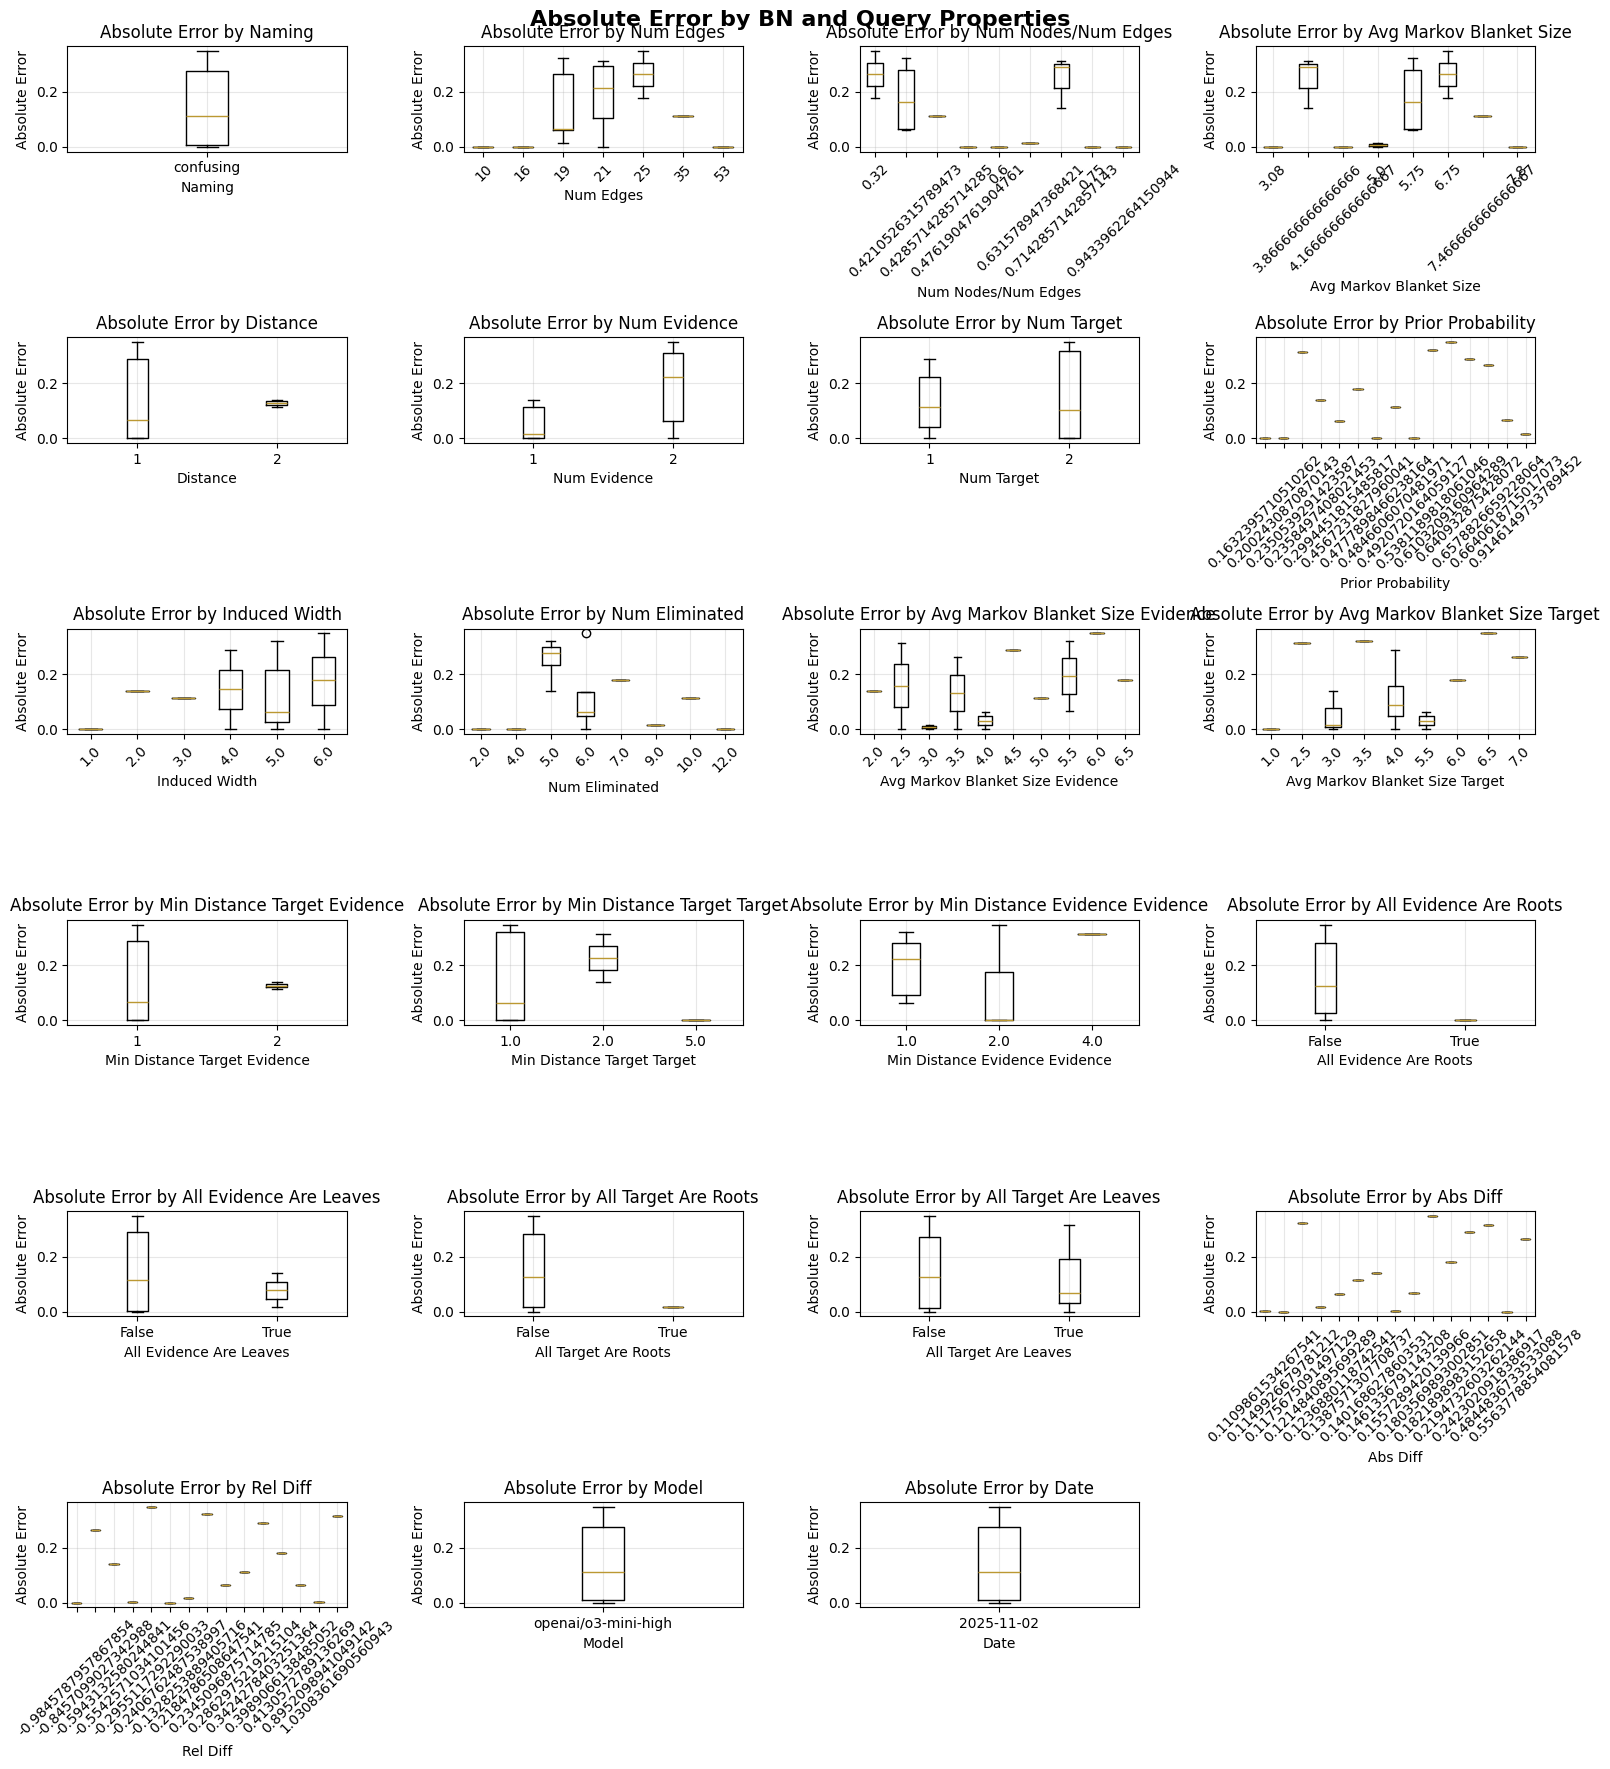


Summary Statistics by Property:

NAMING:
           count      mean       std       min       max
naming                                                  
confusing     15  0.141246  0.134097  0.000012  0.348764

NUM_EDGES:
           count      mean       std       min       max
num_edges                                               
10             1  0.001043       NaN  0.001043  0.001043
16             1  0.000012       NaN  0.000012  0.000012
19             5  0.146215  0.137222  0.015869  0.321986
21             4  0.185945  0.145810  0.000097  0.314156
25             2  0.264189  0.119608  0.179613  0.348764
35             1  0.113182       NaN  0.113182  0.113182
53             1  0.001227       NaN  0.001227  0.001227

NUM_NODES/NUM_EDGES:
                     count      mean       std       min       max
num_nodes/num_edges                                               
0.320000                 2  0.264189  0.119608  0.179613  0.348764
0.421053                 4  0.178801  0

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set up the plotting style
plt.style.use('default')
sns.set_palette("husl")

# Filter to only successful LLM responses with exact inference results
plot_df = full_df[full_df['llm_probability'].notna() & full_df['probability'].notna()].copy()
plot_df['abs_error'] = abs(plot_df['llm_probability'] - plot_df['probability'])

if len(plot_df) > 0:
    # Identify all BN and query property columns (exclude result columns)
    exclude_cols = {'bn_index', 'query_vars', 'query_states', 'evidence', 'probability', 
                   'llm_probability', 'llm_response', 'abs_error', 'rel_error', 'target_tw', 'n', 'seed', 'variant_index',
                   'alpha', 'determinism', 'arity', 'query_index', 
                   'achieved_tw', 'num_nodes'}
    
    # Get all columns that are BN or query properties
    property_cols = [col for col in full_df.columns if col not in exclude_cols]
    
    # Calculate number of subplots needed
    n_props = len(property_cols)
    n_cols = min(4, n_props)  # Max 4 columns
    n_rows = (n_props + n_cols - 1) // n_cols  # Ceiling division
    
    # Create figure with subplots for all properties
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 3*n_rows))
    fig.suptitle('Absolute Error by BN and Query Properties', fontsize=16, fontweight='bold')
    
    # Flatten axes for easier indexing
    if n_props == 1:
        axes = [axes]
    elif n_rows == 1:
        axes = axes.flatten()
    else:
        axes = axes.flatten()
    
    # Create boxplots for each property
    for i, prop in enumerate(property_cols):
        ax = axes[i]
        
        # Get unique values for this property
        unique_vals = sorted(plot_df[prop].unique())
        
        # Create boxplot data
        box_data = []
        labels = []
        
        for val in unique_vals:
            subset = plot_df[plot_df[prop] == val]['abs_error']
            if len(subset) > 0:  # Only include if there's data
                box_data.append(subset.values)
                labels.append(str(val))
        
        if box_data:  # Only plot if we have data
            ax.boxplot(box_data, labels=labels)
            ax.set_title(f'Absolute Error by {prop.replace("_", " ").title()}')
            ax.set_xlabel(prop.replace("_", " ").title())
            ax.set_ylabel('Absolute Error')
            ax.grid(True, alpha=0.3)
            
            # Rotate x-axis labels if there are many unique values
            if len(labels) > 5:
                ax.tick_params(axis='x', rotation=45)
    
    # Hide unused subplots
    for i in range(n_props, len(axes)):
        axes[i].set_visible(False)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics for each property
    print("\nSummary Statistics by Property:")
    print("=" * 50)
    
    for prop in property_cols:
        print(f"\n{prop.upper()}:")
        prop_stats = plot_df.groupby(prop)['abs_error'].agg(['count', 'mean', 'std', 'min', 'max'])
        print(prop_stats.round(6))
        
else:
    print("No successful LLM responses with exact inference results available for plotting.")
